In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, set_seed
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import json
from pathlib import Path

/home/linda/workspace/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_seed(1)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Import easy spam feature datasets

In [3]:
df = pd.read_csv("features.csv", na_values = "None")
df.head()

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,inline,1,0,1,1,ie,1.0,0.0,0.0,7.0,1,2.0,0.0,0,Re: [ILUG] Architecture crossover trouble w RH...
1,1,text/plain,NaN,2,0,8,0,com,1.0,0.0,1.0,3.0,0,1.0,1.0,1,Cash in on your home equity7bit Mortgage Lende...
2,1,text/plain,NaN,4,0,7,1,com,1.0,1.0,0.0,10.0,0,3.0,1.0,1,Are Your Mortgage Rates The Best They Can Be.....
3,1,text/html,NaN,1,1,0,0,cn,0.0,0.0,1.0,3.0,0,3.0,1.0,1,Online Approval for $5000 Now7bit\nFree Card S...
4,1,text/plain,inline,2,0,0,1,ie,1.0,0.0,0.0,7.0,1,3.0,0.0,0,Re: [ILUG] expanding a string multiple timesil...


Import hard spam features dataset

In [4]:
df_s = pd.read_csv("features_hard_spam.csv", na_values = "None")
df_s.head()

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,NaN,21,0,2,0,NaN,NaN,NaN,NaN,3,1,2,1,1,Today's news: Serious PHP flaw found: not spam...
1,1,text/html,NaN,56,1,4,0,com,0.0,0.0,0.0,2,0,2,1,1,NEWS.COM INVESTOR: Techs lose again with Seibe...
2,1,text/html,NaN,47,1,3,0,com,0.0,0.0,0.0,2,0,1,1,1,Triple your dial-up Web surfing speeds! Here's...
3,1,text/html,NaN,25,1,0,0,com,0.0,0.0,0.0,2,0,2,1,1,CNET: Copycat worms and a PGP Outlook flaw: 2....
4,1,multipart/alternative,NaN,0,1,14,0,ie,1.0,NaN,1.0,5,0,3,1,1,Back to School with Buy4Now: multipart/alterna...


Combine these two datasets

In [5]:
df_f = pd.concat([df, df_s], axis = 0, ignore_index = True)
df_f

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,inline,1,0,1,1,ie,1.0,0.0,0.0,7.0,1,2.0,0.0,0,Re: [ILUG] Architecture crossover trouble w RH...
1,1,text/plain,NaN,2,0,8,0,com,1.0,0.0,1.0,3.0,0,1.0,1.0,1,Cash in on your home equity7bit Mortgage Lende...
2,1,text/plain,NaN,4,0,7,1,com,1.0,1.0,0.0,10.0,0,3.0,1.0,1,Are Your Mortgage Rates The Best They Can Be.....
3,1,text/html,NaN,1,1,0,0,cn,0.0,0.0,1.0,3.0,0,3.0,1.0,1,Online Approval for $5000 Now7bit\nFree Card S...
4,1,text/plain,inline,2,0,0,1,ie,1.0,0.0,0.0,7.0,1,3.0,0.0,0,Re: [ILUG] expanding a string multiple timesil...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,1,text/html,NaN,0,1,1,0,com,0.0,0.0,0.0,2.0,0,1.0,1.0,1,New Sony Vaio: When small becomes TOO small [A...
6042,1,text/html,NaN,16,1,11,0,com,0.0,0.0,0.0,2.0,0,3.0,1.0,1,Canon USA Reseller News : July: 2.8.4-2\nCNET ...
6043,1,NaN,NaN,16,0,8,0,com,0.0,0.0,0.0,6.0,1,2.0,1.0,1,The Freedom Rides: \n\n ...
6044,1,text/html,NaN,0,1,1,0,com,0.0,0.0,0.0,2.0,0,1.0,1.0,1,MS/Apple: Can this marriage be saved? (I doubt...


In [6]:
df1 = df_f.map(lambda x: x.lower().strip() if isinstance(x, str) else x)

cleaning feature $content\_type$

In [7]:
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("text/html")[0] + "text/html" if isinstance(x, str) and "text/html" in x else x)
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("text/plain")[0] + "text/plain" if isinstance(x, str) and "text/plain" in x else x)
df1["content_type"] = df1["content_type"].apply(lambda x: x.split("application")[0] + "application" if isinstance(x, str) and "application" in x else x)

cleaning feature $content\_disp$

In [8]:
df1["content_disp"] = df1["content_disp"].apply(lambda x: x.split(";")[0] if isinstance(x, str) and ";" in x else x)
df1["content_disp"] = df1["content_disp"].apply(lambda x: x.split("inline")[0] + "inline" if isinstance(x, str) and "inline" in x else x)

change categorical data into integer

In [9]:
int_col = ["has_subject", "num_html", "has_attachement", "num_exc_mark", "has_list_id", "check_spf", "check_dkim", "from_returnpath_same", "num_received", "is_replied", "time_period", "is_weekday"]
df1[int_col] = df1[int_col].apply(pd.to_numeric, errors = "coerce").astype("Int64")

remove values in feature $domain$ appear less than 15 times

In [10]:
threshold = 15
value_counts = df1["domain"].value_counts()
df1["domain"] = df1["domain"].apply(lambda x: x if isinstance(x, str) and value_counts[x] >= threshold else "Other")

The cleaned dataset

In [11]:
df1.head()

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday,labels,process_content
0,1,text/plain,inline,1,0,1,1,ie,1,0,0,7,1,2,0,0,re: [ilug] architecture crossover trouble w rh...
1,1,text/plain,NaN,2,0,8,0,com,1,0,1,3,0,1,1,1,cash in on your home equity7bit mortgage lende...
2,1,text/plain,NaN,4,0,7,1,com,1,1,0,10,0,3,1,1,are your mortgage rates the best they can be.....
3,1,text/html,NaN,1,1,0,0,cn,0,0,1,3,0,3,1,1,online approval for $5000 now7bit\nfree card s...
4,1,text/plain,inline,2,0,0,1,ie,1,0,0,7,1,3,0,0,re: [ilug] expanding a string multiple timesil...


input content for BERT model

In [12]:
process_content_list = df1.iloc[:, -1].tolist()

This is the label

In [13]:
labels = df1.iloc[:, -2].tolist()

dataset for machine learning-based classifier

In [14]:
df_train = df1.iloc[:, :-2] 
df_train

,has_subject,content_type,content_disp,num_html,has_attachement,num_exc_mark,has_list_id,domain,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,time_period,is_weekday
0,1,text/plain,inline,1,0,1,1,ie,1,0,0,7,1,2,0
1,1,text/plain,NaN,2,0,8,0,com,1,0,1,3,0,1,1
2,1,text/plain,NaN,4,0,7,1,com,1,1,0,10,0,3,1
3,1,text/html,NaN,1,1,0,0,cn,0,0,1,3,0,3,1
4,1,text/plain,inline,2,0,0,1,ie,1,0,0,7,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,1,text/html,NaN,0,1,1,0,com,0,0,0,2,0,1,1
6042,1,text/html,NaN,16,1,11,0,com,0,0,0,2,0,3,1
6043,1,NaN,NaN,16,0,8,0,com,0,0,0,6,1,2,1
6044,1,text/html,NaN,0,1,1,0,com,0,0,0,2,0,1,1


apply one hot encoding to categorical data

In [15]:
one_hot_col = ["content_type", "content_disp", "domain", "time_period"]
encoder = OneHotEncoder(drop = "first", sparse_output = False, handle_unknown = "ignore") 
encoded_cats = encoder.fit_transform(df_train[one_hot_col])
encoded_df = pd.DataFrame(encoded_cats, columns = encoder.get_feature_names_out(one_hot_col)).astype(int)
encoded_df[df_train[one_hot_col].isna()] = pd.NA
df_train1 = df_train.drop(columns = one_hot_col).join(encoded_df)
df_train1

,has_subject,num_html,has_attachement,num_exc_mark,has_list_id,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,...,domain_dk,domain_ie,domain_net,domain_org,domain_ru,domain_uk,domain_us,time_period_2.0,time_period_3.0,time_period_nan
0,1,1,0,1,1,1,0,0,7,1,...,0,1,0,0,0,0,0,1,0,0
1,1,2,0,8,0,1,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,7,1,1,1,0,10,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2,0,0,1,1,0,0,7,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,1,0,1,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
6042,1,16,1,11,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
6043,1,16,0,8,0,0,0,0,6,1,...,0,0,0,0,0,0,0,1,0,0
6044,1,0,1,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


replace na with median values

In [16]:
df_train1 = df_train1.fillna(df_train1.median())
df_train1

,has_subject,num_html,has_attachement,num_exc_mark,has_list_id,check_spf,check_dkim,from_returnpath_same,num_received,is_replied,...,domain_dk,domain_ie,domain_net,domain_org,domain_ru,domain_uk,domain_us,time_period_2.0,time_period_3.0,time_period_nan
0,1,1,0,1,1,1,0,0,7,1,...,0,1,0,0,0,0,0,1,0,0
1,1,2,0,8,0,1,0,1,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,0,7,1,1,1,0,10,0,...,0,0,0,0,0,0,0,0,1,0
3,1,1,1,0,0,0,0,1,3,0,...,0,0,0,0,0,0,0,0,1,0
4,1,2,0,0,1,1,0,0,7,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6041,1,0,1,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
6042,1,16,1,11,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,1,0
6043,1,16,0,8,0,0,0,0,6,1,...,0,0,0,0,0,0,0,1,0,0
6044,1,0,1,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


split the dataset into 80% train, 10% validation, and 10% test

In [17]:
X_train, X_temp, y_train, y_temp = train_test_split(df_train1, labels, test_size = 0.3, random_state = 1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 1)

apply logistic regression on metadata features and output its validation performances

In [18]:
model = LogisticRegression(max_iter=500, random_state=1)
model.fit(X_train, y_train)

X_pred = model.predict(X_train)
X_pred_prob = model.predict_proba(X_train)[:, 1]

y_pred = model.predict(X_val)
y_pred_prob = model.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.96
              precision    recall  f1-score   support

           0     0.9460    0.9897    0.9674       584
           1     0.9797    0.8978    0.9370       323

    accuracy                         0.9570       907
   macro avg     0.9629    0.9438    0.9522       907
weighted avg     0.9580    0.9570    0.9565       907



its training accuracy

In [19]:
accuracy_score(y_train, X_pred)

0.9584120982986768

apply XGBoost on metadata features and output its validation performances

In [20]:
def xgb(X_train, y_train, X_val, y_val, m_d, m_c):
    model_xbg = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=1, max_depth=m_d, min_child_weight=m_c)
    model_xbg.fit(X_train, y_train)

    X_pred = model_xbg.predict(X_train)
    X_pred_prob = model_xbg.predict_proba(X_train)[:, 1]

    y_pred = model_xbg.predict(X_val)
    y_pred_prob = model_xbg.predict_proba(X_val)[:, 1]

    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(classification_report(y_val, y_pred, digits=4))

    return X_pred, X_pred_prob, y_pred, y_pred_prob

In [21]:
X_pred, X_pred_prob, y_pred, y_pred_prob = xgb(X_train, y_train, X_val, y_val, 6, 3)

Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.9681    0.9880    0.9780       584
           1     0.9775    0.9412    0.9590       323

    accuracy                         0.9713       907
   macro avg     0.9728    0.9646    0.9685       907
weighted avg     0.9715    0.9713    0.9712       907



/home/linda/workspace/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:28:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


its training accuracy

In [22]:
accuracy_score(y_train, X_pred)

0.9936200378071833

apply SVM on metadata features and output its validation performances

In [23]:
model_svm = SVC(probability=True, random_state=1)
model_svm.fit(X_train, y_train)

X_pred = model_svm.predict(X_train)
X_pred_prob = model_svm.predict_proba(X_train)[:, 1]

y_pred = model_svm.predict(X_val)
y_pred_prob = model_svm.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.88
              precision    recall  f1-score   support

           0     0.8471    0.9863    0.9114       584
           1     0.9648    0.6780    0.7964       323

    accuracy                         0.8765       907
   macro avg     0.9059    0.8322    0.8539       907
weighted avg     0.8890    0.8765    0.8704       907



its training accuracy

In [24]:
accuracy_score(y_train, X_pred)

0.889413988657845

apply random forest on metadata features and output its validation performances

In [25]:
def rf(X_train, y_train, X_val, y_val, n_est, min_s):
    model_rf = RandomForestClassifier(random_state=1, n_estimators = n_est, min_samples_split=min_s)
    model_rf.fit(X_train, y_train)

    X_pred = model_rf.predict(X_train)
    X_pred_prob = model_rf.predict_proba(X_train)[:, 1]

    y_pred = model_rf.predict(X_val)
    y_pred_prob = model_rf.predict_proba(X_val)[:, 1]

    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(classification_report(y_val, y_pred, digits=4))

    return X_pred, X_pred_prob, y_pred, y_pred_prob

In [26]:
X_pred, X_pred_prob, y_pred, y_pred_prob = rf(X_train, y_train, X_val, y_val, 60, 9)

Accuracy: 0.98
              precision    recall  f1-score   support

           0     0.9699    0.9932    0.9814       584
           1     0.9871    0.9443    0.9652       323

    accuracy                         0.9757       907
   macro avg     0.9785    0.9687    0.9733       907
weighted avg     0.9760    0.9757    0.9756       907



its training accuracy

In [27]:
accuracy_score(y_train, X_pred)

0.9879489603024575

Apply Native Bayes on metadata features and outputs its validation performance

In [28]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)

X_pred = model_nb.predict(X_train)
X_pred_prob = model_nb.predict_proba(X_train)[:, 1]

y_pred = model_nb.predict(X_val)
y_pred_prob = model_nb.predict_proba(X_val)[:, 1]

print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
print(classification_report(y_val, y_pred, digits=4))

Accuracy: 0.90
              precision    recall  f1-score   support

           0     0.8802    0.9812    0.9279       584
           1     0.9570    0.7585    0.8463       323

    accuracy                         0.9019       907
   macro avg     0.9186    0.8698    0.8871       907
weighted avg     0.9076    0.9019    0.8989       907



its training accuracy

In [29]:
accuracy_score(y_train, X_pred)

0.9068998109640832

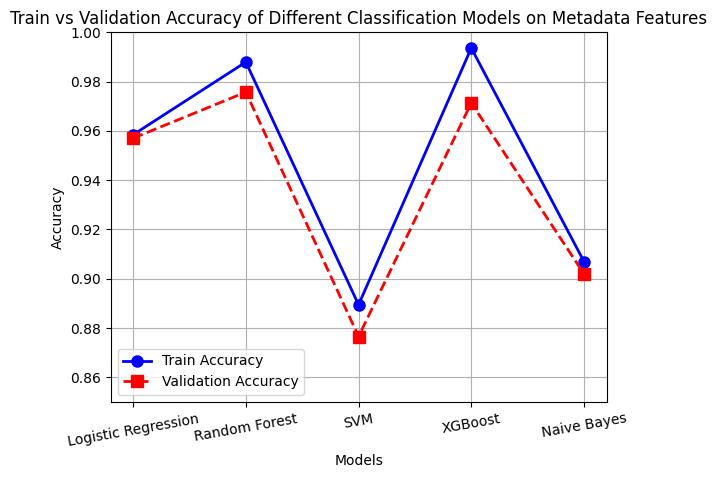

In [30]:
model_name = ["Logistic Regression", "Random Forest", "SVM", "XGBoost", "Naive Bayes"]
val_accuracy = [0.9570, 0.9757, 0.8765, 0.9713, 0.9019]
train_accuracy = [0.9584, 0.9879, 0.8894, 0.9936, 0.9069]
plt.plot(model_name, train_accuracy, marker="o", linestyle="-", color="blue", linewidth=2, markersize=8, label="Train Accuracy")
plt.plot(model_name, val_accuracy, marker="s", linestyle="--", color="red", linewidth=2, markersize=8, label="Validation Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy of Different Classification Models on Metadata Features")
plt.ylim(0.85, 1.0)  
plt.legend()
plt.grid(True)
plt.xticks(rotation = 10)
plt.show()

get the test set prediction of random forest

In [31]:
X_pred, X_pred_prob, y_pred_test, y_pred_prob_test = rf(X_train, y_train, X_test, y_test, 60, 9)

Accuracy: 0.97
              precision    recall  f1-score   support

           0     0.9764    0.9748    0.9756       595
           1     0.9521    0.9551    0.9536       312

    accuracy                         0.9680       907
   macro avg     0.9643    0.9650    0.9646       907
weighted avg     0.9681    0.9680    0.9680       907



processing the actual email content

In [32]:
def text_preprocessing(email_content):

    email_content = email_content.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    email_content = re.sub(r'(?:[A-Za-z0-9+/]{2,4}){4,}', ' ', email_content)
    email_content = re.sub(r'((.{1,4}?))(\1){3,}', r'\1', email_content)
    email_content = re.sub(r'([/+=\\\-])\1{3,}', ' ', email_content)
    email_content = re.sub(r"<[^>]+>", " ", email_content)
    email_content = re.sub(r"https?://\S+|www\.\S+", "[URL]", email_content)
    email_content = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "[EMAIL]", email_content)
    email_content = re.sub(r'[^a-zA-Z0-9.,!?\"\s]', " ", email_content)
    email_content = re.sub(r"\s+", " ", email_content).strip()

    return email_content

In [33]:
preprocessed_content = [text_preprocessing(i) if isinstance(i, str) else "None" for i in process_content_list]

create tokenizer on it

In [36]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", timeout = 30)
tokenized_inputs = tokenizer(preprocessed_content, truncation = True, padding = True, max_length = 512, return_tensors = "pt")

split it in 80% training, 10% validation, and 10% test

In [37]:
attention_mask = tokenized_inputs["attention_mask"]
labels_tensor = torch.tensor(labels)
X_train_bert, X_temp_bert, train_mask_bert, temp_mask_bert, y_train_bert, y_temp_bert = train_test_split(tokenized_inputs["input_ids"], attention_mask, labels_tensor, test_size = 0.3, random_state = 1)
X_val_bert, X_test_bert, val_mask_bert, test_mask_bert, y_val_bert, y_test_bert = train_test_split(X_temp_bert, temp_mask_bert, y_temp_bert, test_size = 0.5, random_state = 1)

create data loader and download the pre-train BERT model

In [38]:
def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)

train_dataset = TensorDataset(X_train_bert, train_mask_bert, y_train_bert)
val_dataset = TensorDataset(X_val_bert, val_mask_bert, y_val_bert)
test_dataset = TensorDataset(X_test_bert, test_mask_bert, y_test_bert)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
val_loader = DataLoader(val_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)

model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

fine-tuning BERT model on email content

In [39]:
def bert_training(model_bert, lr_value, num_epochs, train_loader, device):

    optimizer = optim.AdamW(model_bert.parameters(), lr = lr_value, eps = 1e-8)
    loss_fn = nn.CrossEntropyLoss()

    epochs = num_epochs
    for epoch in range(epochs):
        model_bert.train()
        total_loss = 0
        correct = 0
        total = 0

        train_prob_list = []
        train_predictions = []
        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]

            optimizer.zero_grad()
            outputs = model_bert(input_ids = b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits
            train_probs = F.softmax(logits, dim = 1)
            train_prob_list.extend(train_probs[:, 1].cpu().tolist())

            loss = loss_fn(outputs.logits, b_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim = 1)
            train_predictions.extend(predictions.cpu().tolist())
            correct += (predictions == b_labels).sum().item()
            total += b_labels.size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total
        print(f'Epoch {epoch + 1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.2%}')
    
    return train_prob_list, train_predictions

evaluate the BERT model

In [40]:
def bert_evaluation(model_bert, val_loader1, device):
    model_bert.eval()
    correct = 0
    total = 0

    val_predictions = []
    val_prob_list = []
    with torch.no_grad():
        for batch in val_loader1:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]

            outputs = model_bert(input_ids = b_input_ids, attention_mask = b_input_mask)
            logits = outputs.logits
            val_probs = F.softmax(logits, dim = 1)
            val_prob_list.extend(val_probs[:, 1].cpu().tolist())
            val_preds = torch.argmax(outputs.logits, dim = 1)
            val_predictions.extend(val_preds.cpu().tolist())
            correct += (val_preds == b_labels).sum().item()
            total += b_labels.size(0)

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%}")

    return val_prob_list, val_predictions

The training accuracy

In [41]:
train_prob_list, train_predictions = bert_training(model_bert, 5e-5, 3, train_loader, device)

Epoch 1: Loss = 0.1561, Accuracy = 94.05%
Epoch 2: Loss = 0.0402, Accuracy = 98.72%
Epoch 3: Loss = 0.0204, Accuracy = 99.50%


The validation accuracy

In [42]:
val_prob_list, val_predictions = bert_evaluation(model_bert, val_loader, device)

Accuracy: 97.24%


The test accuracy

In [43]:
test_prob_list, test_predictions = bert_evaluation(model_bert, test_loader, device)

Accuracy: 98.02%


In [44]:
report_bert = classification_report(y_val_bert, val_predictions, target_names = ["Ham", "Spam"], digits=4)
print(report_bert)

              precision    recall  f1-score   support

         Ham     0.9878    0.9692    0.9784       584
        Spam     0.9461    0.9783    0.9619       323

    accuracy                         0.9724       907
   macro avg     0.9669    0.9738    0.9702       907
weighted avg     0.9729    0.9724    0.9725       907



get combined training dataset and validation dataset containing predicted probability from random forest and BERT

In [45]:
comb_df = np.column_stack((train_prob_list, X_pred_prob))
comb_df_val = np.column_stack((val_prob_list, y_pred_prob))

apply random forest on the combined dataset to get the final classification and output the validation performance

In [46]:
def rf_c(comb_df, y_train, comb_df_val, y_val_bert, y_pred, n_est, min_s):
    model_rf = RandomForestClassifier(random_state=1, n_estimators = n_est, min_samples_split=min_s)
    model_rf.fit(comb_df, y_train)

    train_pred = model_rf.predict(comb_df)
    y_pred = model_rf.predict(comb_df_val)

    print(f"Accuracy: {accuracy_score(y_val_bert, y_pred):.2f}")
    print(classification_report(y_val_bert, y_pred, digits=4))

    return train_pred, y_pred

In [101]:
train_pred, y_pred = rf_c(comb_df, y_train, comb_df_val, y_val_bert, y_pred, 100, 3)

Accuracy: 0.98
              precision    recall  f1-score   support

           0     0.9913    0.9760    0.9836       584
           1     0.9578    0.9845    0.9710       323

    accuracy                         0.9791       907
   macro avg     0.9746    0.9803    0.9773       907
weighted avg     0.9794    0.9791    0.9791       907



its training accuracy

In [49]:
accuracy_score(y_train, train_pred)

1.0

apply linear regression on the combined dataset to get the final classification

In [50]:
model_lr = LinearRegression()
model_lr.fit(comb_df, y_train)

LinearRegression()

its training accuracy

In [51]:
train_pred_final = model_lr.predict(comb_df)
train_pred_final1 = [1 if i >= 0.5 else 0 for i in train_pred_final]
accuracy_score(y_train, train_pred_final1)

0.995274102079395

In [52]:
val_pred_final = model_lr.predict(comb_df_val)

In [53]:
val_pred_final1 = [1 if i >= 0.5 else 0 for i in val_pred_final]

output the validation performance

In [54]:
report_final = classification_report(y_val_bert, val_pred_final1, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9878    0.9743    0.9810       584
        Spam     0.9547    0.9783    0.9664       323

    accuracy                         0.9757       907
   macro avg     0.9713    0.9763    0.9737       907
weighted avg     0.9760    0.9757    0.9758       907



apply logistic regression on the combined dataset to get the final classification and output the validation performance

In [84]:
meta_classifier = LogisticRegression(C=0.1)
meta_classifier.fit(comb_df, y_train)

LogisticRegression(C=0.1)

In [85]:
final_preds = meta_classifier.predict(comb_df_val)

In [86]:
report_final = classification_report(y_val_bert, final_preds, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9880    0.9880    0.9880       584
        Spam     0.9783    0.9783    0.9783       323

    accuracy                         0.9846       907
   macro avg     0.9832    0.9832    0.9832       907
weighted avg     0.9846    0.9846    0.9846       907



its training accuracy

In [87]:
final_train_preds = meta_classifier.predict(comb_df)
accuracy_score(y_train, final_train_preds)

0.9969281663516069

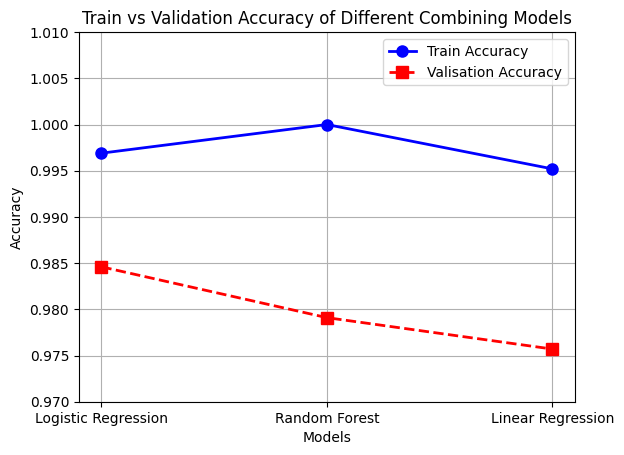

In [92]:
model_name_comb = ["Logistic Regression", "Random Forest", "Linear Regression"]
val_accuracy = [0.9846, 0.9791, 0.9757]
train_accuracy = [0.9969, 1, 0.9952]
plt.plot(model_name_comb, train_accuracy, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label="Train Accuracy")
plt.plot(model_name_comb, val_accuracy, marker='s', linestyle='--', color='red', linewidth=2, markersize=8, label="Valisation Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy of Different Combining Models")
plt.ylim(0.97, 1.01)  
plt.legend()
plt.grid(True)
plt.show()

final hybrid model performance on the test set

In [102]:
comb_df_test = np.column_stack((test_prob_list, y_pred_prob_test))
test_pred_final = meta_classifier.predict(comb_df_test)
report_final_test = classification_report(y_test_bert, test_pred_final, target_names = ["Ham", "Spam"], digits=4)
print(report_final)

              precision    recall  f1-score   support

         Ham     0.9880    0.9880    0.9880       584
        Spam     0.9783    0.9783    0.9783       323

    accuracy                         0.9846       907
   macro avg     0.9832    0.9832    0.9832       907
weighted avg     0.9846    0.9846    0.9846       907



Apply random forest on the whole email (metadata features + vectorized text)

Convert text to vector form

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_full = vectorizer.fit_transform(preprocessed_content) 

Combine metadata features with vectorized text

In [90]:
from scipy.sparse import hstack
X_extra = np.array(np.array(df_train1), dtype=np.float32)
X_combined = hstack([X_full, X_extra])
X_combined = X_combined.toarray()

Split the dataset into train, validation, and test

In [91]:
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X_combined, labels, test_size = 0.3, random_state = 1)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_temp1, y_temp1, test_size = 0.5, random_state = 1)

Run random forest on the data

In [398]:
def rf1(X_train, y_train, X_val, y_val, n_est, min_s, m_d):
    model_rf = RandomForestClassifier(random_state=1, n_estimators = n_est, min_samples_split=min_s, max_depth=m_d)
    model_rf.fit(X_train, y_train)

    X_pred = model_rf.predict(X_train)
    X_pred_prob = model_rf.predict_proba(X_train)[:, 1]

    y_pred = model_rf.predict(X_val)
    y_pred_prob = model_rf.predict_proba(X_val)[:, 1]

    print(f"Accuracy: {accuracy_score(y_val, y_pred):.2f}")
    print(classification_report(y_val, y_pred, digits=4))

    return X_pred, X_pred_prob, y_pred, y_pred_prob

validation performance

In [410]:
X_pred1, X_pred_prob1, y_pred1, y_pred_prob1 = rf1(X_train1, y_train1, X_val1, y_val1, 100, 9, 20)

Accuracy: 0.98
              precision    recall  f1-score   support

           0     0.9653    1.0000    0.9823       584
           1     1.0000    0.9350    0.9664       323

    accuracy                         0.9768       907
   macro avg     0.9826    0.9675    0.9744       907
weighted avg     0.9777    0.9768    0.9767       907



test performance

In [411]:
X_pred2, X_pred_prob2, y_pred_test2, y_pred_prob_test2 = rf1(X_train1, y_train1, X_test1, y_test1, 100, 9, 20)

Accuracy: 0.98
              precision    recall  f1-score   support

           0     0.9752    0.9933    0.9842       595
           1     0.9867    0.9519    0.9690       312

    accuracy                         0.9791       907
   macro avg     0.9810    0.9726    0.9766       907
weighted avg     0.9792    0.9791    0.9790       907



Apply BERT on the whole email

Combine easy spam dataset with hard spam dataset

In [5]:
df_e = pd.read_csv("spam_assassin.csv")

spam_files = [json.load(open(f, "r", encoding = "utf-8")) for f in Path('hard_spam').glob("*.json")]
rows = []
for i in spam_files:
    rows.append({'text': i['text'], 'target': 1})
df_h = pd.DataFrame(rows)

df_f1 = pd.concat([df_e, df_h], axis = 0, ignore_index = True)

clean emails and tokenize them

In [6]:
process_content_list1 = df_f1.iloc[:, 0].tolist()
labels1 = df_f1.iloc[:, 1].tolist()
preprocessed_content1 = [text_preprocessing(i) if isinstance(i, str) else "None" for i in process_content_list1]
tokenizer1 = BertTokenizer.from_pretrained("bert-base-uncased", timeout = 30)
tokenized_inputs1 = tokenizer1(preprocessed_content1, truncation = True, padding = True, max_length = 512, return_tensors = "pt")

Define BERT and split the dataset into train, validation, and test sets

In [7]:
attention_mask1 = tokenized_inputs1["attention_mask"]
labels_tensor1 = torch.tensor(labels1)
X_train_bert1, X_temp_bert1, train_mask_bert1, temp_mask_bert1, y_train_bert1, y_temp_bert1 = train_test_split(tokenized_inputs1["input_ids"], attention_mask1, labels_tensor1, test_size = 0.3, random_state = 1)
X_val_bert1, X_test_bert1, val_mask_bert1, test_mask_bert1, y_val_bert1, y_test_bert1 = train_test_split(X_temp_bert1, temp_mask_bert1, y_temp_bert1, test_size = 0.5, random_state = 1)

def seed_worker(worker_id):
    np.random.seed(1)
    random.seed(1)

train_dataset1 = TensorDataset(X_train_bert1, train_mask_bert1, y_train_bert1)
val_dataset1 = TensorDataset(X_val_bert1, val_mask_bert1, y_val_bert1)
test_dataset1 = TensorDataset(X_test_bert1, test_mask_bert1, y_test_bert1)

train_loader1 = DataLoader(train_dataset1, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
val_loader1 = DataLoader(val_dataset1, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)
test_loader1 = DataLoader(test_dataset1, batch_size = 64, shuffle = False, worker_init_fn = seed_worker)

model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bert.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

Fine-tune BERT

In [8]:
train_prob_list1, train_predictions1 = bert_training(model_bert, 1e-4, 3, train_loader1, device)

Epoch 1: Loss = 0.3097, Accuracy = 85.56%
Epoch 2: Loss = 0.1048, Accuracy = 97.35%
Epoch 3: Loss = 0.1033, Accuracy = 97.42%


validation performance

In [9]:
val_prob_list1, val_predictions1 = bert_evaluation(model_bert, val_loader1, device)
report_bert1 = classification_report(y_val_bert1, val_predictions1, target_names = ["Ham", "Spam"], digits=4)
print(report_bert1)

Accuracy: 97.91%
              precision    recall  f1-score   support

         Ham     0.9796    0.9880    0.9838       584
        Spam     0.9780    0.9628    0.9704       323

    accuracy                         0.9791       907
   macro avg     0.9788    0.9754    0.9771       907
weighted avg     0.9790    0.9791    0.9790       907



test performance

In [10]:
test_prob_list1, test_predictions1 = bert_evaluation(model_bert, test_loader1, device)
report_bert2 = classification_report(y_test_bert1, test_predictions1, target_names = ["Ham", "Spam"], digits=4)
print(report_bert2)

Accuracy: 98.24%
              precision    recall  f1-score   support

         Ham     0.9866    0.9866    0.9866       595
        Spam     0.9744    0.9744    0.9744       312

    accuracy                         0.9824       907
   macro avg     0.9805    0.9805    0.9805       907
weighted avg     0.9824    0.9824    0.9824       907



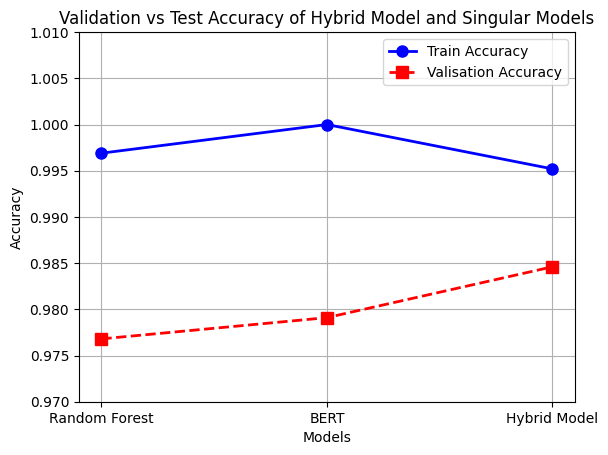

In [103]:
model_name_comb = ["Random Forest", "BERT", "Hybrid Model"]
val_accuracy = [0.9768, 0.9791, 0.9846]
test_accuracy = [0.9791, 0.9824, 0.9846]
plt.plot(model_name_comb, train_accuracy, marker='o', linestyle='-', color='blue', linewidth=2, markersize=8, label="Train Accuracy")
plt.plot(model_name_comb, val_accuracy, marker='s', linestyle='--', color='red', linewidth=2, markersize=8, label="Valisation Accuracy")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Validation vs Test Accuracy of Hybrid Model and Singular Models")
plt.ylim(0.97, 1.01)  
plt.legend()
plt.grid(True)
plt.show()